<a href="https://colab.research.google.com/github/elsa9421/Interactive-IPython-Demos/blob/main/FCN_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Application Demo :Semantic Segmentation with Torchvision
<br> This technique marks parts of an image with a category. And the concept of category encapsulates also information about what can we do with those objects.Semantic segmentation is intelligent, and it is used to understand what is in the image rather than just identifying the structure or region. It involves understanding what's in the image at pixel level.


<br> **This notebook demonstrates semantic segmentation of an image using torchvision's pretrained FCN-ResNet101. The model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.**






#FCN with Resnet-101

FCN-ResNet101 is contructed by a Fully-Covolutional Network model with a ResNet-101 backbone. The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.


<br>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape `(N,C, H, W)` where :-
<br>
<br> `N` : the batch size
<br> `C` : number of channels (which is 3)
<br> `H` and `W` : height and width of the image which is to be at least 224 pixels. 

<br>The images have to be loaded in to a range of `[0, 1]` and then normalized using <br/>`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

The model returns an `OrderedDict` with two Tensors that are of the **same** height and width as the input Tensor, but with 21 classes. `output['out']` contains the semantic masks, and `output['aux']` contains the auxillary loss values per-pixel. In inference mode, `output['aux']` is not useful. So, `output['out']` is of shape `(N, 21, H, W)`. 

And in `.eval()` mode the model just has one key `'out'` and thus to get the output we need to get the value stored in that key.

More information can be found [here](https://pytorch.org/hub/pytorch_vision_fcn_resnet101/)

In [ ]:
from torchvision import models   # to import segmentation.fcn_resnet101
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import numpy as np

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
fcn

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti


# Function Definition : segment


1. Apply the following preprocessing steps to the image:
    - Resize the image to `(256 x 256)`
    - CenterCrop it to `(224 x 224)`
    - Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
    - Normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`
    -  unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/>A batch dimension is required while passing it to the models

2. Pass input image to the model
3. Convert output obtained from model to a 2D image where each pixel corresponds to a class label







In [ ]:
def segment(net, path):
  '''
  The Function takes in model and image path as input and plots the segmented image

  Inputs:
  - net : model
  - path : URL of image 
  '''

  # store image from URL in img
  img = Image.open(path)
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(img); plt.axis('off')
  plt.title("Original Image")
  # Comment the Resize and CenterCrop for better inference results

  # Apply transformations to the obtained image
  trf = T.Compose([T.Resize(256),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
  
  # trf will be of shape [C x H x W]
  #unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]`
  inp = trf(img).unsqueeze(0)

  # Pass the input through the net
  out = net(inp)['out']  #out will be of shape [1 x 21 x H x W] as the model was trained on 21 classes

  # to convert 21 channeled output into a 2D image where each pixel belongs to a class
  # Each (x,y) of the 2D image will correspond to a number between 0-20 representing a class
  # We take a max index for each pixel position, which represents the class<br/>
  om = torch.argmax(out.squeeze(), dim=0).detach().numpy()
  #Now we have a 2D image where each pixel belongs to a class
  rgb = decode_segmap(om)
  plt.subplot(1,2,2)
  plt.imshow(rgb); plt.axis('off')
  plt.title("Segmented Image")


In [ ]:
# Define the helper function for visualization
def decode_segmap(image, nc=21):
  '''
  The function takens in a 2D image where each pixel corresponds to a class label 
  and converts this into a segmentation map where each class label is converted 
  into a RGB color and thus helping in easy visualization.

  Input:

  -image: 2D image where each pixel corresponds to a class label
  -nc: Number of classes
  '''
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
 
  for l in range(0, nc):
    idx = image == l

    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb


def generate_colormap():
  '''
  To generate a horizontal colormap with labels and corresponding classes
  '''
  import matplotlib.pyplot as plt
  import matplotlib as mpl

  import numpy as np
  label_colors = np.array([[0, 0, 0],  # 0=background
                # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
                # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0],
                # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]])



  label_colors=np.divide(label_colors,255)
  labels=["background","aeroplane","bicycle","bird","boat","bottle",
          "bus", "car", "cat", "chair", "cow",
          "dining table", "dog", "horse", "motorbike", "person",
          "potted plant", "sheep", "sofa", "train", "tv/monitor"]
  fig, ax = plt.subplots(figsize=(20, 1))
  fig.subplots_adjust(bottom=0.5)

  cmap = mpl.colors.ListedColormap(label_colors)
  norm = mpl.colors.Normalize(vmin=0, vmax=21)
  bounds=range(21)
  cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                  #ticks=bounds,
                                  norm=norm,
                                  orientation='horizontal')
  cb1.set_ticks(bounds)
  cb1.set_ticklabels(labels)

  fig.show()


# Load images

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

!wget -nv "https://media.mercola.com/ImageServer/Public/2017/November/Nonlead/dog-walking.jpg" -O person.png

!wget "https://i.pinimg.com/originals/d9/7c/83/d97c836441b47dad1c901c203f65e687.jpg" -O dining.jpg
!wget "https://i0.wp.com/www.horsetalk.co.nz/wp-content/uploads/2019/11/Robin-Emma-Sophia.jpg?fit=800%2C458&ssl=1" -O horse

2020-06-21 22:26:26 URL:https://media.mercola.com/ImageServer/Public/2017/November/Nonlead/dog-walking.jpg [10722/10722] -> "person.png" [1]
--2020-06-21 22:26:27--  https://i.pinimg.com/originals/d9/7c/83/d97c836441b47dad1c901c203f65e687.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.210.196.239, 2606:4700::6812:fb0, 2606:4700::6812:eb0
Connecting to i.pinimg.com (i.pinimg.com)|23.210.196.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79434 (78K) [image/jpeg]
Saving to: ‘dining.jpg’

dining.jpg          100%[===================>]  77.57K  --.-KB/s    in 0.03s   

2020-06-21 22:26:27 (2.77 MB/s) - ‘dining.jpg’ saved [79434/79434]

--2020-06-21 22:26:28--  https://i0.wp.com/www.horsetalk.co.nz/wp-content/uploads/2019/11/Robin-Emma-Sophia.jpg?fit=800%2C458&ssl=1
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91105 (89K) [image/jpeg]
Savin

Testing

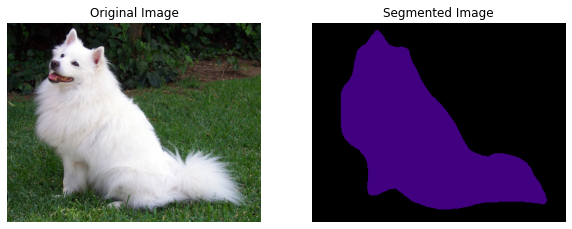

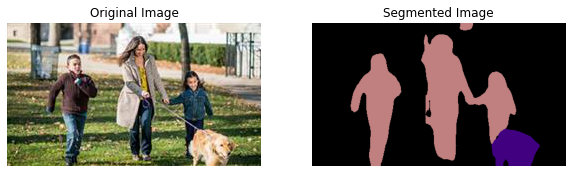

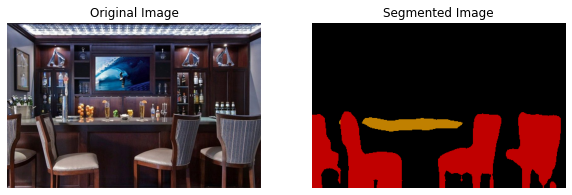

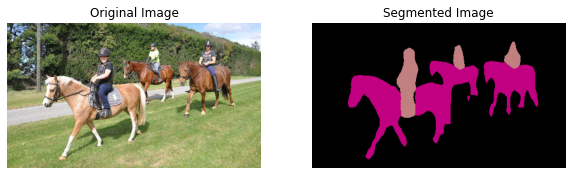

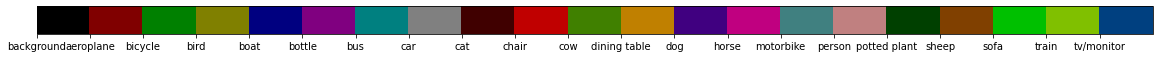

In [ ]:
segment(fcn, 'dog.jpg')
segment(fcn,'person.png')
segment(fcn,'dining.jpg')
segment(fcn,'horse')
generate_colormap()


